https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/


In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import glob

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
files = glob.glob('../documents/comments/comments/*.txt')

In [3]:
print(len(files))

445441


In [4]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [7]:
data = []

for f in files:
    with open(f, 'r') as fin:
        data.append(fin.read())

In [8]:

data_words = list(sent_to_words(data))



In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/Users/wickes1/anaconda/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['as', 'much', 'as', 'rape', 'is', 'horrible', 'horrible', 'thing', 'you', 'have', 'to', 'remember', 'that', 'this', 'story', 'is', 'set', 'years', 'in', 'the', 'past', 'where', 'women', 'were', 'considered', 'property', 'and', 'were', 'subject', 'to', 'all', 'types', 'of', 'assault', 'you', 'can', 'use', 'the', 'mindset', 'of', 'the', 'current', 'era', 'when', 'looking', 'far', 'back', 'in', 'time', 'when', 'the', 'world', 'was', 'very', 'different', 'place']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out



In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
nlp.max_length = 9297925
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['much', 'rape', 'horrible', 'horrible', 'thing', 'remember', 'story', 'set', 'year', 'woman', 'consider', 'property', 'subject', 'type', 'assault', 'use', 'mindset', 'current', 'era', 'look', 'far', 'back', 'time', 'world', 'different', 'place']]


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)]]


In [13]:
id2word[0]

'assault'

In [13]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [14]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics(30))
doc_lda = lda_model[corpus]

[(0,
  '0.093*"life" + 0.066*"day" + 0.053*"someone" + 0.038*"home" + 0.036*"wrong" '
  '+ 0.029*"experience" + 0.025*"follow" + 0.023*"area" + '
  '0.020*"responsibility" + 0.018*"officer"'),
 (1,
  '0.646*"br" + 0.023*"write" + 0.022*"question" + 0.013*"line" + '
  '0.013*"wonder" + 0.012*"book" + 0.012*"answer" + 0.008*"isis" + '
  '0.008*"short" + 0.007*"response"'),
 (2,
  '0.067*"american" + 0.037*"help" + 0.036*"president" + 0.035*"white" + '
  '0.034*"support" + 0.031*"america" + 0.030*"gun" + 0.028*"understand" + '
  '0.023*"anyone" + 0.021*"deal"'),
 (3,
  '0.094*"police" + 0.078*"person" + 0.046*"thank" + 0.041*"guy" + 0.030*"cop" '
  '+ 0.019*"murder" + 0.017*"religious" + 0.015*"prevent" + 0.013*"wear" + '
  '0.013*"video"'),
 (4,
  '0.090*"something" + 0.031*"possible" + 0.028*"mr" + 0.028*"interesting" + '
  '0.024*"defense" + 0.021*"ability" + 0.019*"thousand" + 0.018*"ground" + '
  '0.017*"texas" + 0.017*"train"'),
 (5,
  '0.081*"state" + 0.051*"poor" + 0.039*"school" 

In [15]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.860890693813014

Coherence Score:  0.42224533818964594


In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
29     12.661783        1       1 -0.267922  0.368774
11     11.467079        1       2 -0.246476 -0.302131
21      9.180098        1       3 -0.197585 -0.088067
2       4.370143        1       4 -0.083802 -0.007705
1       4.258638        1       5 -0.056988 -0.007077
23      4.076137        1       6 -0.074519 -0.011813
19      3.996577        1       7 -0.053939 -0.010860
5       3.207838        1       8 -0.022951 -0.005393
9       2.861042        1       9  0.019161  0.001821
18      2.805046        1      10  0.003673 -0.002722
16      2.657573        1      11  0.027696  0.001883
20      2.648786        1      12  0.029733  0.000641
27      2.592850        1      13 -0.032430 -0.002955
0       2.508504        1      14  0.028654  0.003413
6       2.376675        1      15  0.031633  0.003071
14      2.266754        1      16  0.046788  0.000502
13      2.259529        1      17  0.031346  0.006320
8       2.240851        1      18  0.028455  0.000903
28      2.073148        1      19  0.060639  0.004069
24      2.062920        1      20  0.054660  0.003964
17      2.025387        1      21  0.043032  0.003870
15      1.901572        1      22  0.055569  0.001944
7       1.891389        1      23  0.038568  0.004355
22      1.857096        1      24  0.075030  0.006297
26      1.828508        1      25  0.057071  0.001546
10      1.821858        1      26  0.064366  0.000405
3       1.708621        1      27  0.060385  0.005378
4       1.668713        1      28  0.086344  0.006457
12      1.371822        1      29  0.102108  0.008051
25      1.353065        1      30  0.091701  0.005058, topic_info=     Category           Freq          Term          Total  loglift  logprob
term                                                                       
106   Default  447279.000000            br  447279.000000  30.0000  30.0000
430   Default  123637.000000        people  123637.000000  29.0000  29.0000
98    Default  112585.000000         would  112585.000000  28.0000  28.0000
59    Default   95926.000000          make   95926.000000  27.0000  27.0000
24    Default   64141.000000          year   64141.000000  26.0000  26.0000
891   Default   53299.000000          want   53299.000000  25.0000  25.0000
164   Default   61871.000000          work   61871.000000  24.0000  24.0000
22    Default   49705.000000         woman   49705.000000  23.0000  23.0000
60    Default   44110.000000           man   44110.000000  22.0000  22.0000
125   Default   84462.000000           get   84462.000000  21.0000  21.0000
306   Default   76659.000000          good   76659.000000  20.0000  20.0000
21    Default   43109.000000           use   43109.000000  19.0000  19.0000
19    Default   69711.000000          time   69711.000000  18.0000  18.0000
126   Default   71991.000000            go   71991.000000  17.0000  17.0000
299   Default   47286.000000      american   47286.000000  16.0000  16.0000
528   Default   45926.000000       country   45926.000000  15.0000  15.0000
859   Default   42345.000000         state   42345.000000  14.0000  14.0000
23    Default   44841.000000         world   44841.000000  13.0000  13.0000
264   Default   69377.000000         think   69377.000000  12.0000  12.0000
586   Default   38040.000000          life   38040.000000  11.0000  11.0000
856   Default   66083.000000           say   66083.000000  10.0000  10.0000
559   Default   34374.000000         black   34374.000000   9.0000   9.0000
394   Default   60660.000000           see   60660.000000   8.0000   8.0000
381   Default   51593.000000          need   51593.000000   7.0000   7.0000
82    Default   59488.000000          take   59488.000000   6.0000   6.0000
329   Default   59046.000000          know   59046.000000   5.0000   5.0000
61    Default   58656.000000          many   58656.000000   4.0000   4.0000
95    Default   57134.000

In [15]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=25, id2word=id2word)

In [18]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(16,
  [('war', 0.04002728118366057),
   ('deal', 0.03455497569153694),
   ('iran', 0.024142419205381963),
   ('military', 0.014294054737338264),
   ('israel', 0.012622903696350428),
   ('iraq', 0.012317597256169958),
   ('isis', 0.01218904717609397),
   ('support', 0.011908736584817165),
   ('russia', 0.011194569473283901),
   ('attack', 0.00987693115250503)]),
 (13,
  [('president', 0.048172014575660824),
   ('obama', 0.033351351981986535),
   ('congress', 0.018369299333828523),
   ('run', 0.01723762449395468),
   ('bill', 0.015892059220427704),
   ('public', 0.015752058209309288),
   ('lie', 0.015592612613313319),
   ('office', 0.014311214469882283),
   ('politician', 0.011015357333136295),
   ('give', 0.010910356574797485)]),
 (19,
  [('life', 0.06241036555246037),
   ('child', 0.05536264192312142),
   ('family', 0.039429057261377264),
   ('live', 0.03842643685970476),
   ('parent', 0.022698517921380605),
   ('love', 0.021319455793805422),
   ('friend', 0.020124023776426667),
   (

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [30]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=62, limit=65, step=1)

for i, model in enumerate(model_list):
    topics = [str(tn) + "," + ",".join([w for w, n in words]) for tn, words in [list(r) for r in model.show_topics(100, formatted=False)]]
    numtopics = len(topics)
    fname = "../topic_words/" + str(numtopics).zfill(3) + "fullset.csv"
    
    with open(fname, 'w') as fout:

        print("\n".join(topics), file = fout)

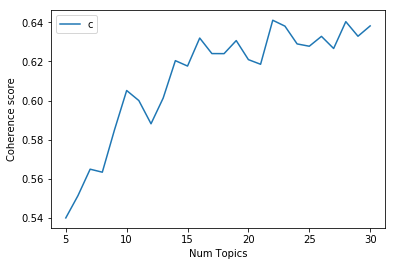

In [21]:
# Show graph
limit=31; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.5401
Num Topics = 6  has Coherence Value of 0.5514
Num Topics = 7  has Coherence Value of 0.565
Num Topics = 8  has Coherence Value of 0.5634
Num Topics = 9  has Coherence Value of 0.585
Num Topics = 10  has Coherence Value of 0.6051
Num Topics = 11  has Coherence Value of 0.6
Num Topics = 12  has Coherence Value of 0.5882
Num Topics = 13  has Coherence Value of 0.6013
Num Topics = 14  has Coherence Value of 0.6204
Num Topics = 15  has Coherence Value of 0.6176
Num Topics = 16  has Coherence Value of 0.6319
Num Topics = 17  has Coherence Value of 0.624
Num Topics = 18  has Coherence Value of 0.624
Num Topics = 19  has Coherence Value of 0.6306
Num Topics = 20  has Coherence Value of 0.6209
Num Topics = 21  has Coherence Value of 0.6185
Num Topics = 22  has Coherence Value of 0.641
Num Topics = 23  has Coherence Value of 0.638
Num Topics = 24  has Coherence Value of 0.6289
Num Topics = 25  has Coherence Value of 0.6278
Num Topics = 26  has Cohere

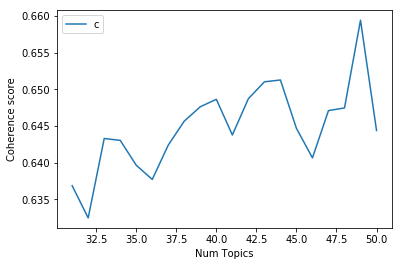

Num Topics = 31  has Coherence Value of 0.6368
Num Topics = 32  has Coherence Value of 0.6325
Num Topics = 33  has Coherence Value of 0.6433
Num Topics = 34  has Coherence Value of 0.643
Num Topics = 35  has Coherence Value of 0.6396
Num Topics = 36  has Coherence Value of 0.6377
Num Topics = 37  has Coherence Value of 0.6424
Num Topics = 38  has Coherence Value of 0.6457
Num Topics = 39  has Coherence Value of 0.6476
Num Topics = 40  has Coherence Value of 0.6486
Num Topics = 41  has Coherence Value of 0.6438
Num Topics = 42  has Coherence Value of 0.6487
Num Topics = 43  has Coherence Value of 0.651
Num Topics = 44  has Coherence Value of 0.6513
Num Topics = 45  has Coherence Value of 0.6447
Num Topics = 46  has Coherence Value of 0.6406
Num Topics = 47  has Coherence Value of 0.6471
Num Topics = 48  has Coherence Value of 0.6474
Num Topics = 49  has Coherence Value of 0.6594
Num Topics = 50  has Coherence Value of 0.6444


In [23]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=31, limit=51, step=1)

# Show graph
limit=51; start=31; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [24]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 31  has Coherence Value of 0.6368
Num Topics = 32  has Coherence Value of 0.6325
Num Topics = 33  has Coherence Value of 0.6433
Num Topics = 34  has Coherence Value of 0.643
Num Topics = 35  has Coherence Value of 0.6396
Num Topics = 36  has Coherence Value of 0.6377
Num Topics = 37  has Coherence Value of 0.6424
Num Topics = 38  has Coherence Value of 0.6457
Num Topics = 39  has Coherence Value of 0.6476
Num Topics = 40  has Coherence Value of 0.6486
Num Topics = 41  has Coherence Value of 0.6438
Num Topics = 42  has Coherence Value of 0.6487
Num Topics = 43  has Coherence Value of 0.651
Num Topics = 44  has Coherence Value of 0.6513
Num Topics = 45  has Coherence Value of 0.6447
Num Topics = 46  has Coherence Value of 0.6406
Num Topics = 47  has Coherence Value of 0.6471
Num Topics = 48  has Coherence Value of 0.6474
Num Topics = 49  has Coherence Value of 0.6594
Num Topics = 50  has Coherence Value of 0.6444


In [25]:
print("make github see this change")

make github see this change


In [39]:
# Can take a long time to run.
# model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=51, limit=61, step=1)

# # Show graph
# limit=57; start=51; step=1;
# x = range(start, limit, step)
# plt.plot(x, coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 51  has Coherence Value of 0.6368
Num Topics = 52  has Coherence Value of 0.6325
Num Topics = 53  has Coherence Value of 0.6433
Num Topics = 54  has Coherence Value of 0.643
Num Topics = 55  has Coherence Value of 0.6396
Num Topics = 56  has Coherence Value of 0.6377


In [32]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=61, limit=65, step=1)

# # Show graph
# limit=61; start=51; step=1;
# x = range(start, limit, step)
# plt.plot(x, coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

KeyboardInterrupt: 